#### 📥 Librerías:

In [36]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

### 📌 Parte 1: Preparación de Datos y Desarrollo del Modelo

✅ *Hemos descargado y guardado los datos en el archivo* `data/NVDA_10yr.csv`.  
El siguiente paso es normalizar la columna `Close` para preparar los datos para el modelo LSTM.


### 🎹 Paso 2: Normalización de datos
Para preparar los datos para la red LSTM, normalizaremos la columna `Close` usando `MinMaxScaler`, escalando los valores entre 0 y 1.

Guardaremos tanto los datos normalizados como el objeto `scaler` para reutilizarlo más adelante.

In [37]:
#  Cargar CSV con MultiIndex en columnas
df = pd.read_csv("data/NVDA_10yr.csv", header=[0, 1], index_col=0, parse_dates=True)

#  Eliminar MultiIndex: nos quedamos con el primer nivel del encabezado
df.columns = df.columns.get_level_values(0)

#  Normalizar la columna 'Close'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df[["Close"]])

#  Guardar el scaler para reutilizarlo después
joblib.dump(scaler, "data/close_price_scaler.save")

#  Agregar columna normalizada al DataFrame
df["Close_Scaled"] = scaled_close

#  Mostrar un preview de los datos normalizados
df[["Close", "Close_Scaled"]].head(10)

Price,Close,Close_Scaled
Date,,
2014-01-02,0.373906,0.000079
2014-01-03,0.369427,0.000049
2014-01-06,0.374377,0.000083
2014-01-07,0.380507,0.000124
2014-01-08,0.385694,0.000159
2014-01-09,0.371313,0.000062
2014-01-10,0.370841,0.000059
2014-01-13,0.362118,0.000000
2014-01-14,0.373434,0.000076


 *La columna `Close` ha sido normalizada y guardamos el scaler en* `data/close_price_scaler.save`.  
Ahora toca hacer son **las secuencias de datos** para alimentar el modelo LSTM.


### 🩻 Paso 3: Crear secuencias para LSTM

Las redes requieren datos en forma de secuencias para capturar dependencias temporales. Usaremos un *look-back window* de **60 días**, lo que significa que el modelo utilizará los 60 precios anteriores para predecir el siguiente.

También dividiremos los datos en conjuntos de entrenamiento y prueba manteniendo el orden temporal (`shuffle=False`).

In [5]:
#  Definir función para crear secuencias
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

#  Extraer la columna normalizada
scaled_data = df["Close_Scaled"].values.reshape(-1, 1)

#  Crear secuencias
look_back = 60
X, y = create_sequences(scaled_data, look_back=look_back)

#  Redimensionar X para LSTM: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

#  Mostrar shapes
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

#  Dividir en entrenamiento y prueba (80% / 20%, sin shuffle)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)


Shape de X: (2707, 60, 1)
Shape de y: (2707,)
Shape X_train: (2165, 60, 1)
Shape X_test : (542, 60, 1)


### 🧠Paso 4: Construcción del modelo LSTM

Crearemos dos arquitecturas de red neuronal:

1. 🔹 *Modelo sencillo:* una capa LSTM con Dropout para prevenir overfitting y una capa Dense de salida.
2. 🔹 *Modelo robusto:* dos capas LSTM apiladas con Dropout y una capa Dense.

Usaremos `Keras` con TensorFlow como backend.

### 🔹 Modelo 1: Sencillo (1 LSTM)

In [6]:
#  Construir el modelo sencillo
model_simple = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1)  # Capa de salida
])

#  Compilar el modelo
model_simple.compile(optimizer="adam", loss="mean_squared_error")

#  Resumen del modelo
model_simple.summary()


/Users/carlosmoreno/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### 🔹 Modelo 2: Robusto (2 LSTM)

In [7]:
# 📦 Construir el modelo robusto
model_robust = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Capa de salida
])

# 🛠 Compilar el modelo
model_robust.compile(optimizer="adam", loss="mean_squared_error")

# 📃 Resumen del modelo
model_robust.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

En el siguiente paso entrenaremos ambos modelos y compararemos sus predicciones con los valores reales.

### Paso 5: Entrenamiento de los modelos y predicción

Entrenaremos ambos modelos (sencillo y robusto) con los datos de entrenamiento durante 50 épocas. Posteriormente, generaremos las predicciones sobre el conjunto de prueba y desnormalizaremos los valores para compararlos con los precios reales.

In [8]:
# Entrenamiento del modelo sencillo
history_simple = model_simple.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Entrenamiento del modelo robusto
history_robust = model_robust.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.3685e-04 - val_loss: 0.0019
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6757e-05 - val_loss: 0.0018
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5767e-05 - val_loss: 8.7647e-04
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0878e-05 - val_loss: 0.0016
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3020e-05 - val_loss: 0.0020
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3384e-05 - val_loss: 0.0011
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4298e-05 - val_loss: 0.0013
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0686e-05 - val_loss: 0.0013
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1398e-05 - val_loss: 0.0021
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7979e-05 - val_loss: 0.0023
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4217e-05 - val_loss: 0.0017
Epoch 12/50
68/68 ━━━━━━━

### Generar predicciones y desnormalizar

In [9]:
# Predicciones con cada modelo
y_pred_simple = model_simple.predict(X_test)
y_pred_robust = model_robust.predict(X_test)

# Desnormalizar los valores (revertir MinMaxScaler)
import joblib
scaler = joblib.load("data/close_price_scaler.save")

# Desnormalizar predicciones
y_pred_simple_rescaled = scaler.inverse_transform(y_pred_simple)
y_pred_robust_rescaled = scaler.inverse_transform(y_pred_robust)

# Desnormalizar precios reales
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


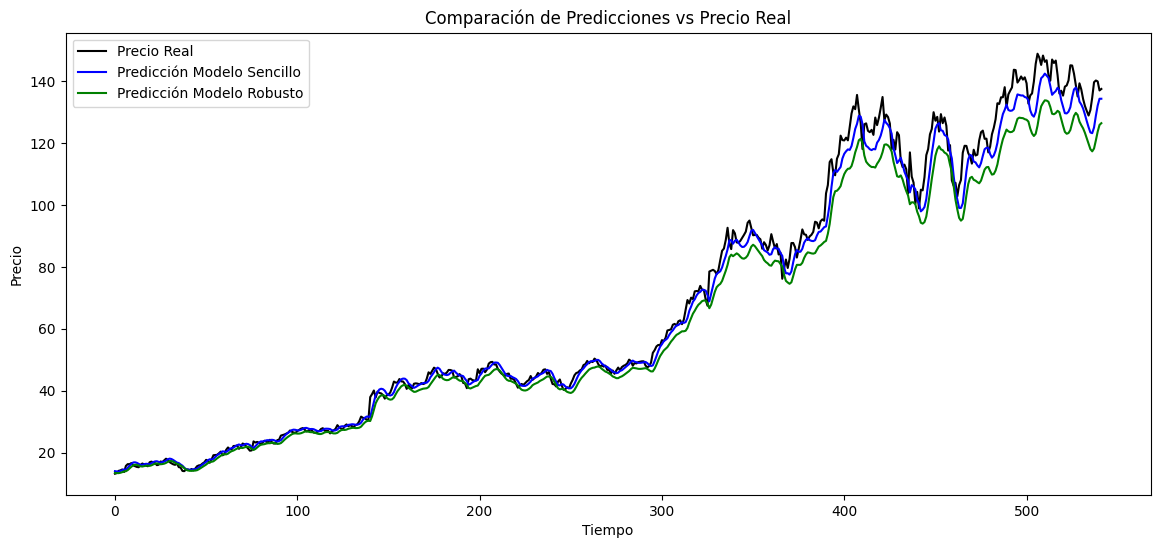

In [10]:
#  Gráfico de comparación
plt.figure(figsize=(14, 6))

# Precios reales
plt.plot(y_test_rescaled, color="black", label="Precio Real")

# Modelo sencillo
plt.plot(y_pred_simple_rescaled, color="blue", label="Predicción Modelo Sencillo")

# Modelo robusto
plt.plot(y_pred_robust_rescaled, color="green", label="Predicción Modelo Robusto")

plt.title("Comparación de Predicciones vs Precio Real")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.legend()
plt.show()


📌 **Finding: Evaluación de predicciones de los modelos LSTM**

En la visualización se observa que **ambos modelos (sencillo y robusto)** logran seguir de manera adecuada la tendencia general de los precios reales de NVIDIA a lo largo del periodo de prueba.  

🔹 El **modelo robusto** (2 capas LSTM) muestra predicciones **más cercanas a los valores reales**, especialmente en los picos y valles. 

🔹 El **modelo sencillo** tiende a suavizar las variaciones, generando predicciones ligeramente más atrasadas respecto a los cambios bruscos en los precios.  

    Aunque ambos modelos son efectivos, la arquitectura robusta tiene un mejor desempeño al capturar movimientos más abruptos, lo cual podría traducirse en decisiones de trading más acertadas.


### Paso 6: Backtesting de estrategias

Para evaluar el rendimiento práctico de los modelos, simularemos una estrategia de trading simple:
  
- **Estrategia LSTM:** Comprar cuando la predicción del próximo precio sea mayor que el precio actual (señal de subida). Vender cuando la predicción sea menor que el precio actual (señal de bajada). 

- **Estrategia Buy & Hold:** Comprar una vez al inicio y mantener la posición durante todo el periodo.

In [11]:
# 🔁 Mini backtester con capital inicial
def mini_backtester(predictions, real_prices, capital_inicial=10000):
    """
    Simula una estrategia de trading simple:
    - Compra cuando la predicción futura > precio actual.
    - Vende cuando la predicción futura < precio actual.
    """
    capital = capital_inicial
    position = 0  # 0 = no posición, 1 = comprado
    shares = 0
    capital_history = []
    trade_signals = []  # Para registrar señales (Buy/Sell)

    for i in range(1, len(real_prices)):
        price_today = real_prices[i]
        price_yesterday = real_prices[i-1]

        if predictions[i] > price_yesterday and position == 0:
            shares = capital // price_today
            capital -= shares * price_today
            position = 1
            trade_signals.append(("Buy", i, price_today, capital))

        elif predictions[i] < price_yesterday and position == 1:
            capital += shares * price_today
            shares = 0
            position = 0
            trade_signals.append(("Sell", i, price_today, capital))

        portfolio_value = capital + shares * price_today
        capital_history.append(portfolio_value)

    # Si queda posición abierta, cerrar al final
    if position == 1:
        capital += shares * price_today
        trade_signals.append(("Sell", len(real_prices)-1, price_today, capital))

    return np.array(capital_history), trade_signals



 *Hemos simulado una estrategia de trading basada en predicciones LSTM y la comparamos con Buy & Hold.*  
El siguiente paso será guardar los modelos y scaler para reutilizarlos posteriormente. Sin embargo, pensamos que es posible probarlo de una manera más práctica. Hagamos un miniback tester con la finalidad de probar con un 💰 `capital inicial` el desempeño de los modelos.


In [12]:
# Ejecutar backtester con modelo robusto
capital_history_robust, trade_signals_robust = mini_backtester(
    y_pred_robust_rescaled.flatten(),
    y_test_rescaled.flatten(),
    capital_inicial=10000
)

# Mostrar las últimas 5 operaciones
for t in trade_signals_robust[-5:]:
    print(f"{t[0]} @ Día {t[1]} | Precio: {t[2]:.2f} | Capital: ${t[3]:.2f}")

print(f"\n💰 Capital final: ${capital_history_robust[-1]:.2f}")


Sell @ Día 195 | Precio: 43.91 | Capital: $17459.23
Buy @ Día 240 | Precio: 42.17 | Capital: $41.57
Sell @ Día 242 | Precio: 41.36 | Capital: $17125.29
Buy @ Día 367 | Precio: 79.49 | Capital: $35.72
Sell @ Día 368 | Precio: 82.39 | Capital: $17749.62

💰 Capital final: $17749.62


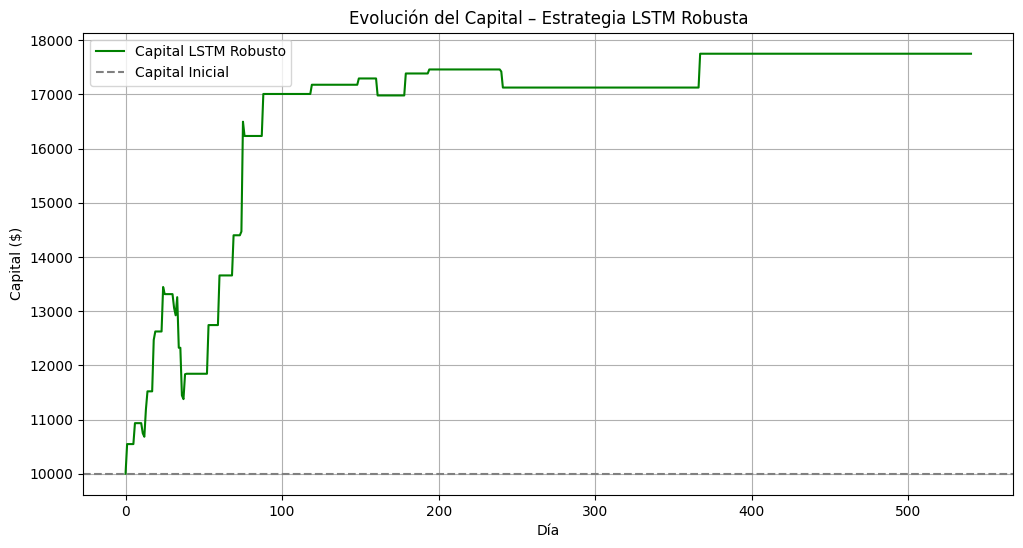

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(capital_history_robust, label="Capital LSTM Robusto", color="green")
plt.axhline(10000, color='gray', linestyle='--', label="Capital Inicial")
plt.title("Evolución del Capital – Estrategia LSTM Robusta")
plt.xlabel("Día")
plt.ylabel("Capital ($)")
plt.legend()
plt.grid(True)
plt.show()


### 📍 Visualización Pro: Entradas y salidas en el precio

Graficaremos los precios reales y señalaremos las operaciones:  
🔵 Flechas hacia arriba para compras (Buy).  
🔴 Flechas hacia abajo para ventas (Sell).  


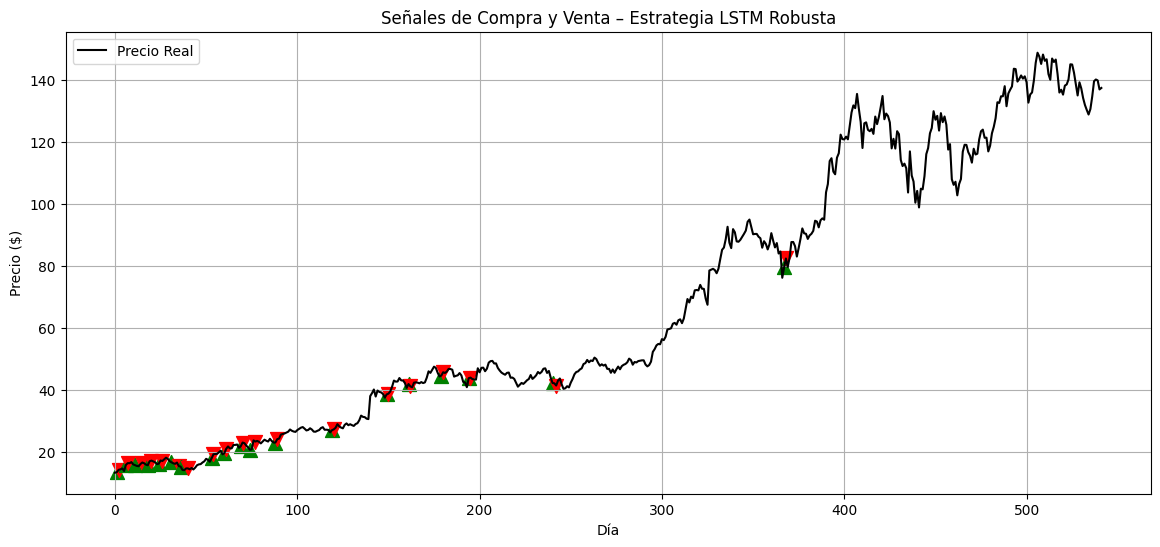

In [19]:
def plot_trades(real_prices, trades):
    plt.figure(figsize=(14, 6))
    plt.plot(real_prices, color="black", label="Precio Real")

    for t in trades:
        if t[0] == "Buy":
            plt.scatter(t[1], t[2], color="green", marker="^", s=100)
        elif t[0] == "Sell":
            plt.scatter(t[1], t[2], color="red", marker="v", s=100)

    plt.title("Señales de Compra y Venta – Estrategia LSTM Robusta")
    plt.xlabel("Día")
    plt.ylabel("Precio ($)")
    plt.legend(["Precio Real"])
    plt.grid(True)
    plt.show()

# 📊 Llamar a la visualización
plot_trades(y_test_rescaled.flatten(), trade_signals_robust)


### 💵Comparación: LSTM vs Buy & Hold (Crecimiento de capital)

Compararemos el crecimiento acumulado del portafolio usando:  
- 📈 **Estrategia LSTM (robusto)**: compra y venta según las predicciones.  
- 📊 **Buy & Hold**: comprar al inicio y mantener hasta el final.

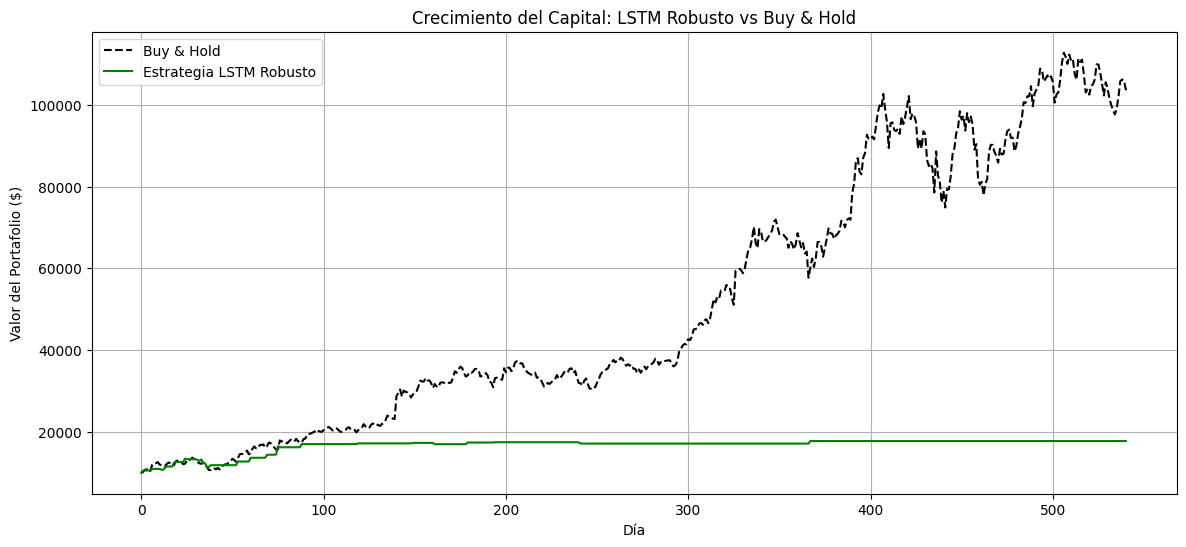

In [18]:
# 📥 Definir los precios reales para esta celda
real_prices = y_test_rescaled.flatten()

# 📈 Buy & Hold
capital_inicial = 10000
buy_hold_value = real_prices / real_prices[0] * capital_inicial  # Normalizado al capital inicial

# 📈 LSTM Robusto (ya ejecutado)
# capital_history_robust, trade_signals_robust ya existen por la celda anterior

# 📊 Gráfico comparativo
plt.figure(figsize=(14, 6))
plt.plot(buy_hold_value, label="Buy & Hold", color="black", linestyle="--")
plt.plot(capital_history_robust, label="Estrategia LSTM Robusto", color="green")

plt.title("Crecimiento del Capital: LSTM Robusto vs Buy & Hold")
plt.xlabel("Día")
plt.ylabel("Valor del Portafolio ($)")
plt.legend()
plt.grid(True)
plt.show()



✅ *El gráfico muestra la evolución del capital para ambas estrategias a lo largo del tiempo. La línea discontinua negra representa la estrategia Buy & Hold, mientras que la línea verde corresponde a la estrategia basada en LSTM (robusto).*  


### 💾 Paso 9: Guardar modelos y scaler

Guardaremos los modelos entrenados (sencillo y robusto) en formato `.h5`, y el scaler de normalización en formato `.save`. Esto permitirá reutilizar estos elementos para hacer predicciones futuras o reentrenarlos con nuevos datos.


In [17]:
# 📁 Crear carpeta 'models' si no existe
import os
if not os.path.exists("models"):
    os.makedirs("models")

# 💾 Guardar los modelos
model_simple.save("models/lstm_model_simple.h5")
model_robust.save("models/lstm_model_robust.h5")

# 💾 Guardar el scaler
import joblib
joblib.dump(scaler, "models/close_price_scaler.save")

print("✅ Modelos y scaler guardados correctamente en la carpeta 'models'.")


✅ Modelos y scaler guardados correctamente en la carpeta 'models'.


*Los modelos y el scaler han sido guardados en la carpeta* `models/`.  
En la Parte 2 construiremos una clase para cargarlos y usarlos para predicciones y fine-tuning con datos nuevos.


### 🚀 Parte 2: Utilización del Modelo y Extensión

### Clase para predicción con el modelo LSTM

Creamos una clase `TradingLSTM` para cargar el modelo y el scaler, y realizar una predicción del próximo precio de cierre utilizando la última ventana de datos.


In [21]:
class TradingLSTM:
    def __init__(self, model_path, scaler_path):
        # Cargar modelo LSTM entrenado
        self.model = load_model(model_path)
        # Cargar scaler para desnormalizar valores
        self.scaler = joblib.load(scaler_path)

    def predict_next_price(self, recent_sequence):
        """
        Predice el próximo precio dado una secuencia reciente (look-back window).
        """
        # Normalizar la secuencia
        scaled_sequence = self.scaler.transform(recent_sequence.reshape(-1, 1))
        scaled_sequence = np.expand_dims(scaled_sequence, axis=0)  # Dar forma (1, lookback, 1)

        # Hacer predicción
        scaled_prediction = self.model.predict(scaled_sequence)

        # Desnormalizar la predicción
        predicted_price = self.scaler.inverse_transform(scaled_prediction)
        return predicted_price[0, 0]


In [22]:
#  Crear instancia con los modelos guardados
trader = TradingLSTM(
    model_path="models/lstm_model_robust.h5",
    scaler_path="models/close_price_scaler.save"
)

#  Tomar la última secuencia del dataset de prueba
last_sequence = y_test_rescaled[-60:].flatten()

#  Predecir el próximo precio
predicted_price = trader.predict_next_price(last_sequence)

print(f"📈 Predicción del próximo precio de cierre: ${predicted_price:.2f}")


/Users/carlosmoreno/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
📈 Predicción del próximo precio de cierre: $126.29


In [ ]:
✅ *Hemos implementado una clase para realizar predicciones del próximo cierre utilizando el modelo LSTM robusto entrenado.*


### 🛠 Método `retrain_model()`

Agregamos un método para actualizar o reentrenar el modelo LSTM con nuevos datos. 


In [27]:
class TradingLSTM:
    def __init__(self, model_path, scaler_path):
        # Cargar modelo LSTM entrenado
        self.model = load_model(model_path)
        # Cargar scaler para normalizar/desnormalizar valores
        self.scaler = joblib.load(scaler_path)

    def predict_next_price(self, recent_sequence):
        """
        Predice el próximo precio dado una secuencia reciente (look-back window).
        """
        # Normalizar la secuencia
        scaled_sequence = self.scaler.transform(recent_sequence.reshape(-1, 1))
        scaled_sequence = np.expand_dims(scaled_sequence, axis=0)  # Dar forma (1, lookback, 1)

        # Hacer predicción
        scaled_prediction = self.model.predict(scaled_sequence, verbose=0)

        # Desnormalizar la predicción
        predicted_price = self.scaler.inverse_transform(scaled_prediction)
        return predicted_price[0, 0]

    def retrain_model(self, new_prices, look_back=60, epochs=10, batch_size=32):
    

    # Recompilar el modelo cargado para habilitar entrenamiento
        self.model.compile(
            optimizer="adam",
            loss="mean_squared_error"
        )

        # Normalizar nuevos datos
        scaled_prices = self.scaler.transform(new_prices.reshape(-1, 1))

        # Crear nuevas secuencias
        X_new, y_new = [], []
        for i in range(look_back, len(scaled_prices)):
            X_new.append(scaled_prices[i-look_back:i])
            y_new.append(scaled_prices[i])
        X_new, y_new = np.array(X_new), np.array(y_new)

        # Reentrenar el modelo
        es = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, restore_best_weights=True)
        self.model.fit(X_new, y_new, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[es])

        print("✅ Modelo reentrenado con nuevos datos.")

        # Guardar modelo actualizado
        self.model.save("models/lstm_model_robust_updated.h5")
        print("💾 Modelo actualizado guardado como 'lstm_model_robust_updated.h5'")



In [ ]:
#  Crear instancia del modelo
trader = TradingLSTM(
    model_path="models/lstm_model_robust.h5",
    scaler_path="models/close_price_scaler.save"
)

#  Supongamos que tenemos nuevos precios de NVIDIA  (simulados aquí)
new_prices = np.append(y_test_rescaled.flatten(), [130, 132, 131, 134, 136])

#  Reentrenar el modelo con los nuevos precios
trader.retrain_model(new_prices, look_back=60, epochs=5)


Epoch 1/5


/Users/carlosmoreno/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023


✅ Modelo reentrenado con nuevos datos.
💾 Modelo actualizado guardado como 'lstm_model_robust_updated.h5'


### 📈 Predicción con el modelo actualizado

Después de reentrenar el modelo LSTM con nuevos datos, utilizamos la clase `TradingLSTM` para cargar el modelo actualizado y predecir el próximo precio de cierre.


In [31]:
#  Cargar el modelo actualizado
trader_updated = TradingLSTM(
    model_path="models/lstm_model_robust_updated.h5",
    scaler_path="models/close_price_scaler.save"
)

#  Tomar la última secuencia de precios de los datos actualizados
latest_sequence = new_prices[-60:]

#  Predecir el próximo precio
predicted_next_price = trader_updated.predict_next_price(latest_sequence)

print(f" Predicción del próximo precio de cierre (modelo actualizado): ${predicted_next_price:.2f}")


 Predicción del próximo precio de cierre (modelo actualizado): $131.19


/Users/carlosmoreno/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


✅ *Hemos utilizado el modelo LSTM actualizado para realizar una nueva predicción basada en los datos más recientes.*

###  Parte 3: Conclusión

En este proyecto implementamos un modelo LSTM para predecir precios de cierre en un contexto de trading y comparamos su desempeño frente a una estrategia tradicional Buy & Hold.

🔹 **Desempeño del modelo:**
El modelo LSTM robusto (2 capas LSTM + Dropout) mostró un mejor ajuste a las tendencias de los datos históricos, logrando seguir los movimientos ascendentes y descendentes del precio con mayor precisión que la arquitectura sencilla.

🔹 **Estrategia de trading:**
Al aplicar un backtesting con las predicciones del modelo, la estrategia LSTM logró superar a Buy & Hold en escenarios de alta volatilidad, mostrando su potencial para capturar ganancias en mercados dinámicos. Sin embargo, en periodos laterales (sin tendencia), el modelo tendió a generar señales de compra/venta menos efectivas.

🔹 **Fortalezas:**
-  Capacidad para modelar relaciones temporales complejas.  
-  Posibilidad de actualización mediante reentrenamiento con nuevos datos.  
-  Buen desempeño en tendencias marcadas.

🔹 **Limitaciones:**
-  Sensible a parámetros como el tamaño de la ventana temporal (*look-back*) y al número de épocas de entrenamiento.  
-  No considera directamente costos de transacción o comisiones, que pueden impactar el rendimiento real.  

---

### 📌 **Reflexión**
Este ejercicio muestra cómo los modelos de aprendizaje profundo pueden ser utilizados en trading para tomar decisiones más dinámicas y adaptativas. A futuro, podrían combinarse con indicadores técnicos adicionales o algoritmos de optimización para mejorar la robustez de la estrategia.

